In [1]:
# Import libraries for generic data preprocessing
import os
import numpy as np
import pandas as pd
from itertools import chain
import matplotlib.pyplot as plt

# Import libraries for preprocessing embeddings
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from sentence_transformers import SentenceTransformer

# Import libraries for clustering and topic classification
import hdbscan
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Set Random Seed

In [2]:
np.random.seed(10)
os.environ["TOKENIZERS_PARALLELISM"] = 'false'

### Load Preprocessed Data

In [3]:
articles = pd.read_parquet('../data/proc_articles.gzip')
articles = articles.reset_index(drop=True)

In [4]:
articles.head()

,title,author,publication,content,party
0,Breitbart Launches ’Border Wall Construction C...,Milo,Breitbart,Last weekend at church I confessed my sin of p...,right
1,IDF Airstrike Eliminates 4 Islamic State-Linke...,Breitbart Jerusalem,Breitbart,The Times of Israel reports: An Israeli airst...,right
2,Oracle Funds Anti-Google Effort that Outs Hill...,Chriss W. Street,Breitbart,The Oracle Corporation is using its deep finan...,right
3,Silicon Valley Urges Giving Election Day Off t...,Chriss W. Street,Breitbart,Apparently worried about the populist movement...,right
4,Illegal Migrant Abandoned in Desert Calls 911 ...,Bob Price,Breitbart,A severely dehydrated illegal alien called 911...,right


### Perform Stemming and Remove Stop Words

In [5]:
# Load in stop words, stemmer, and regex tokenizer
stop = stopwords.words('english')
punc = RegexpTokenizer(r'\w+')
# stemmer = PorterStemmer()

# Define function for de-lemmatizing words, removing whitespace, and stop words
def reformat_articles(w):
    # lowecase and remove stop words
    words = [word.lower() for word in w.split() if word.lower() not in stop]
    # remove punctuation
    words = [punc.tokenize(word) for word in words]
    # remove whitespace
    words = list(chain.from_iterable(words))
    # remove stems
    # words = [stemmer.stem(word) for word in words]  # TODO -- SEE IF IMPROVED AFTER DELETING THIS LINE
    # convert from list to string
    new_article = ' '.join(words)
    return new_article

# Apply lemmatization, whitespace removal, and stop word removal
articles['content'] = articles['content'].apply(reformat_articles)
articles.head()

,title,author,publication,content,party
0,Breitbart Launches ’Border Wall Construction C...,Milo,Breitbart,last weekend church confessed sin personal van...,right
1,IDF Airstrike Eliminates 4 Islamic State-Linke...,Breitbart Jerusalem,Breitbart,times israel reports israeli airstrike killed ...,right
2,Oracle Funds Anti-Google Effort that Outs Hill...,Chriss W. Street,Breitbart,oracle corporation using deep financial resour...,right
3,Silicon Valley Urges Giving Election Day Off t...,Chriss W. Street,Breitbart,apparently worried populist movement led donal...,right
4,Illegal Migrant Abandoned in Desert Calls 911 ...,Bob Price,Breitbart,severely dehydrated illegal alien called 911 p...,right


### Embed Articles

In [6]:
# Load in pre-trained DistilBERT model
# DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased , runs 60% faster while preserving over 95% of BERT's performances as measured on the GLUE language understanding benchmark
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

  0%|          | 0.00/245M [00:00<?, ?B/s]

In [7]:
# Encode embeddings
embeddings = model.encode(articles['content'], show_progress_bar=True)

Batches:   0%|          | 0/1318 [00:00<?, ?it/s]

### Standardize Embeddings

In [8]:
# Perform mean-centering standardization on embeddings
std_embeddings = StandardScaler(with_mean=True).fit_transform(embeddings)

### Neighborhood-Based Dimensionality Reduction

In [9]:
# Perform non-linear dimensionality reduction
# The smaller the value, the more localized the dimensionality reduction
# The larger the value, the more globalized the dimensionality reduction
# n_neighbors = 15
# n_components = 5
# min_dist = 0.01
# metric = cosine
umap_embeddings = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.01, metric='cosine', random_state=42).fit_transform(std_embeddings)

# Perform min-max standardization on embeddings
std_umap_embeddings = MinMaxScaler().fit_transform(umap_embeddings)

### Density-Based Clustering

In [10]:
# Perform density-based clustering on dimensionality reduced embeddings
# The smaller the value, the more clusters returned
# The larger the value, the fewer clusters returned
# min_cluster_size=100
# metric=euclidean
cluster = hdbscan.HDBSCAN(min_cluster_size=100, metric='euclidean').fit(std_umap_embeddings)

In [11]:
# Frequencies of each cluster/label
unique, counts = np.unique(cluster.labels_, return_counts=True)
np.asarray((unique, counts)).T

array([[   -1, 13328],
       [    0,   457],
       [    1,   786],
       [    2,   120],
       [    3,   371],
       [    4,  1969],
       [    5,  4002],
       [    6,   249],
       [    7,   530],
       [    8,   261],
       [    9,   269],
       [   10,   571],
       [   11,   350],
       [   12,   113],
       [   13, 12238],
       [   14,   239],
       [   15,   252],
       [   16,  1399],
       [   17,   347],
       [   18,  1079],
       [   19,   188],
       [   20,   184],
       [   21,   339],
       [   22,   732],
       [   23,   650],
       [   24,  1127]])

### Plot Clusters

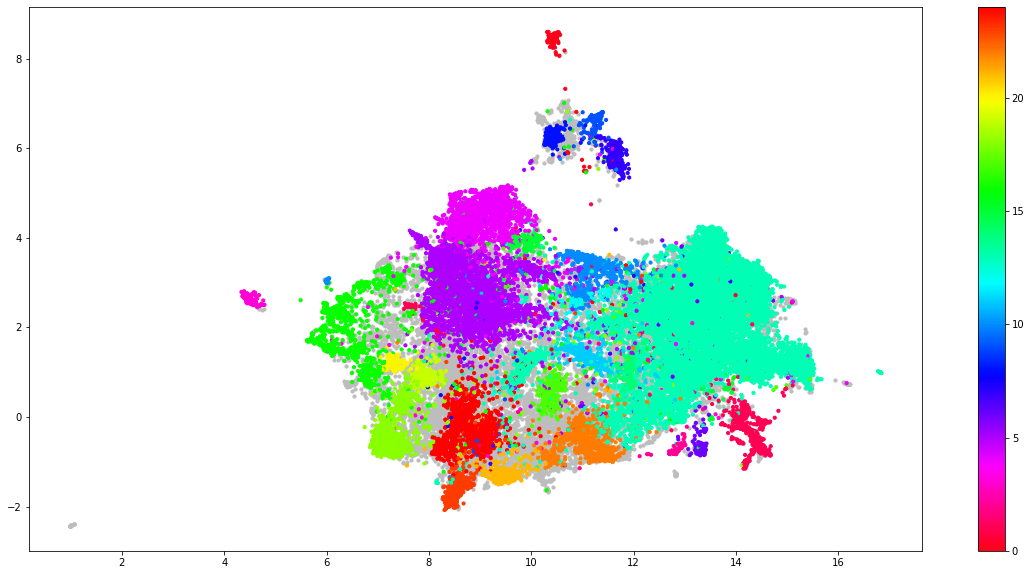

In [12]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.01, metric='cosine', random_state=42).fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=10)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=10, cmap='hsv_r')
plt.colorbar()

### Saving Cluster Data

In [13]:
# Check if number of clusters equals number of articles
articles.shape[0] == len(cluster.labels_)

True

In [14]:
# Assign respective cluster to each article
articles['cluster'] = pd.Series(cluster.labels_, index=articles.index)
# articles[articles['cluster'] == 13].head(10)
articles.head(15)

,title,author,publication,content,party,cluster
0,Breitbart Launches ’Border Wall Construction C...,Milo,Breitbart,last weekend church confessed sin personal van...,right,-1
1,IDF Airstrike Eliminates 4 Islamic State-Linke...,Breitbart Jerusalem,Breitbart,times israel reports israeli airstrike killed ...,right,4
2,Oracle Funds Anti-Google Effort that Outs Hill...,Chriss W. Street,Breitbart,oracle corporation using deep financial resour...,right,13
3,Silicon Valley Urges Giving Election Day Off t...,Chriss W. Street,Breitbart,apparently worried populist movement led donal...,right,-1
4,Illegal Migrant Abandoned in Desert Calls 911 ...,Bob Price,Breitbart,severely dehydrated illegal alien called 911 p...,right,5
5,Exclusive - Coulter to Iowa: Don’t Embarrass N...,Julia Hahn,Breitbart,conservative columnist new york times best sel...,right,13
6,Eight Pro-Second Amendment Smackdowns from NRA...,AWR Hawkins,Breitbart,leadership forum speakers ranging president do...,right,13
7,MSNBC ’Counter-Terrorism Analyst’ Calls for IS...,Ben Kew,Breitbart,another extraordinary outburst msnbc analyst m...,right,-1
8,White House Defends John Kerry Calls for Media...,Charlie Spiering,Breitbart,white house criticize secretary state john ker...,right,13
9,Northwestern to Quadruple Safe Spaces for Blac...,Tom Ciccotta,Breitbart,according task force report northwestern unive...,right,12


In [16]:
# Check if cluster propely added to first row
articles['content'][11]

'recent search engine results indicate google whose ceo supporter hillary clinton s presidential campaign suppressing negative search results democratic party s presidential nominee searches hillary clinton s across three different search engines provide quite different results searched google first suggested searches provided hillary clinton s headquarters hillary clinton s health plan hillary clinton s healthcare plan search results bing return suggestions hillary clinton s health hillary clinton s health issues hillary clinton s health weight search results yahoo return suggestions hillary clinton s health problems hillary clinton s health hillary clinton s health issues earlier august new york times tech columnist farhad manjoo called google fix search results related clinton s health google fix this shouldn t give quarter conspiracy theorists tweeted isn t first time google accused favouring one presidential candidate another june wikileaks founder julian assange accused google di

In [47]:
# Save cluster data as CSV
articles.to_parquet('../data/cluster_articles.gzip', compression='gzip')

### Topic Modeling

In [17]:
# Assign articles to topics
docs_df = pd.DataFrame(articles['content'])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_df.columns = ['Doc', 'Topic', 'Doc_ID']
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
docs_per_topic.head()

,Topic,Doc
0,-1,last weekend church confessed sin personal van...
1,0,miami ap person direct knowledge negotiations ...
2,1,international nuclear accord signed iran abrog...
3,2,sen jeff flake says president barack obama rig...
4,3,scientists said thursday first time detected g...


In [18]:
# Compute c-TF-IDF scores for each word
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(articles['content']))

In [19]:
# Extract top words for each topic
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)
topic_sizes

,Topic,Size
0,-1,13328
14,13,12238
6,5,4002
5,4,1969
17,16,1399
25,24,1127
19,18,1079
2,1,786
23,22,732
24,23,650


### Test Topics

In [21]:
# Topic: Politics
top_n_words[13][:20]

[('republicans', 0.002577901667856221),
 ('democrats', 0.002455884947857724),
 ('hillary', 0.002383321342845069),
 ('senate', 0.0023442060974544756),
 ('comey', 0.0023340120182832086),
 ('republican', 0.002321380613864116),
 ('presidential', 0.002289435354189384),
 ('voters', 0.0022734041080611964),
 ('election', 0.0022625122769683),
 ('gop', 0.0022536956584001014),
 ('democratic', 0.002227342717866935),
 ('cruz', 0.0022176332903043063),
 ('donald', 0.002196862100507445),
 ('nominee', 0.0021294454795941675),
 ('candidate', 0.0021218125041105296),
 ('sanders', 0.002119111245519993),
 ('vote', 0.002011952316850944),
 ('committee', 0.0019856385933093228),
 ('russia', 0.0019271953342247289),
 ('sen', 0.0019110898353155495)]

In [22]:
# Topic: Crime
top_n_words[5][:20]

[('officers', 0.005303951365955631),
 ('officer', 0.004661908819540735),
 ('police', 0.004503551223668294),
 ('shooting', 0.004301524085026871),
 ('prison', 0.003564461576939283),
 ('shot', 0.003446941260483141),
 ('charges', 0.0032754002078278625),
 ('authorities', 0.0031785037974360066),
 ('county', 0.003150062479530337),
 ('murder', 0.0031373123972697784),
 ('death', 0.0030584667287498384),
 ('prosecutors', 0.002983654043116315),
 ('gun', 0.002977645894100253),
 ('arrested', 0.0029285583717790684),
 ('attorney', 0.002901454916605701),
 ('enforcement', 0.0029006030475776778),
 ('charged', 0.002871524394046409),
 ('case', 0.0027001342318225233),
 ('criminal', 0.0026951428385685585),
 ('man', 0.002692527706273033)]

In [23]:
# Topic: War/Terrorism
top_n_words[4][:20]

[('isis', 0.008936729984583038),
 ('syria', 0.008890535024609314),
 ('forces', 0.008098446444081354),
 ('syrian', 0.007921766227576114),
 ('islamic', 0.007846559380773914),
 ('attack', 0.006320995814249615),
 ('turkey', 0.005942456010392001),
 ('fighters', 0.0056448554827100645),
 ('aleppo', 0.005644540575826877),
 ('killed', 0.00558510711161753),
 ('attacks', 0.005496194406213875),
 ('iraqi', 0.005405395396764282),
 ('iraq', 0.005393469660583266),
 ('mosul', 0.005347848382045916),
 ('civilians', 0.0053019464803219),
 ('military', 0.0052571576839020575),
 ('militants', 0.0044997691352170275),
 ('turkish', 0.0043173509736926085),
 ('assad', 0.004297605253900946),
 ('terrorist', 0.004256971274124419)]

In [24]:
# Topic: Global Warming
top_n_words[16][:20]

[('storm', 0.008004244133613328),
 ('snow', 0.006200055116771901),
 ('water', 0.005706044040997945),
 ('weather', 0.005677505403868105),
 ('hurricane', 0.0049397213667533016),
 ('rain', 0.004386566045731643),
 ('dogs', 0.003997677407188145),
 ('flooding', 0.003784508808993236),
 ('animals', 0.0036994601827075343),
 ('coast', 0.003628100133636701),
 ('animal', 0.0036224378310831585),
 ('ice', 0.003565864274714733),
 ('climate', 0.0035502781438434324),
 ('temperatures', 0.003531960187129339),
 ('sea', 0.003478344859734298),
 ('emergency', 0.003373315402381358),
 ('area', 0.0033486514257755453),
 ('winds', 0.003309450661357792),
 ('fish', 0.003288110645721336),
 ('zoo', 0.003285579419727103)]

In [25]:
# Topic: Pop Culture/Entertainment
top_n_words[24][:20]

[('fashion', 0.005311010429239112),
 ('movie', 0.005217431975592134),
 ('film', 0.004986879938473318),
 ('character', 0.0036635758191412324),
 ('love', 0.0036398436391434042),
 ('characters', 0.003215713800507733),
 ('movies', 0.0030349791491615648),
 ('comedy', 0.0029605809860199345),
 ('dress', 0.0029373386168843937),
 ('woman', 0.0028191406016929016),
 ('hollywood', 0.0027242028233974746),
 ('series', 0.0026639278197085918),
 ('star', 0.0026245376452670903),
 ('ms', 0.002605566775602692),
 ('tv', 0.002601105298803943),
 ('girl', 0.0024987272586408783),
 ('married', 0.002467331979220689),
 ('designer', 0.0024357111451470516),
 ('book', 0.0023749484646262502),
 ('mother', 0.002327263799853156)]

In [26]:
# Topic: Food
top_n_words[18][:20]

[('food', 0.010485602466457664),
 ('eat', 0.0055733556531302655),
 ('restaurant', 0.005416537347182638),
 ('foods', 0.0049724398715332),
 ('eating', 0.00496690699094125),
 ('wine', 0.004350971228383281),
 ('restaurants', 0.004269987972935941),
 ('cheese', 0.0041382147757164384),
 ('chicken', 0.004049439964312035),
 ('cooking', 0.004023124709702984),
 ('meat', 0.003953737966793197),
 ('chef', 0.003702843404309341),
 ('sugar', 0.003649393983960691),
 ('recipe', 0.0036377795005135202),
 ('diet', 0.0035354003056667998),
 ('meal', 0.0031952524213298937),
 ('study', 0.0031373502826151133),
 ('dish', 0.0031235012205737805),
 ('bread', 0.0031047182564311196),
 ('ingredients', 0.0030610717172262244)]

In [27]:
# Topic: Nuclear Weapons
top_n_words[1][:20]

[('korea', 0.027219008436240453),
 ('north', 0.01806032782137588),
 ('nuclear', 0.01734268733070658),
 ('korean', 0.016323388174181348),
 ('missile', 0.01465137255646643),
 ('china', 0.013698253618882912),
 ('iran', 0.013625511914411224),
 ('kim', 0.012612909732646838),
 ('south', 0.009280001228424149),
 ('pyongyang', 0.00864100690938145),
 ('chinese', 0.007465840177691239),
 ('japan', 0.007448375426518177),
 ('missiles', 0.007311517968911036),
 ('sanctions', 0.006906185609654261),
 ('iranian', 0.006693787933248847),
 ('ballistic', 0.006689825430363567),
 ('beijing', 0.00624893063101314),
 ('weapons', 0.006056181906687214),
 ('jong', 0.005920810565032379),
 ('test', 0.005644123274946575)]

In [28]:
# Topic: Business/Finance
top_n_words[22][:20]

[('growth', 0.006636051981120915),
 ('economy', 0.005908252388277264),
 ('billion', 0.005649116732571176),
 ('investors', 0.005622859782083743),
 ('company', 0.005460535610989439),
 ('market', 0.005330839989010573),
 ('stock', 0.005244764739110531),
 ('percent', 0.005065427380079172),
 ('bank', 0.00476092525776131),
 ('rate', 0.004722718562310435),
 ('prices', 0.004470476775739222),
 ('jobs', 0.004314719077909466),
 ('economic', 0.004263520939092173),
 ('rates', 0.0038775022562580557),
 ('revenue', 0.0038422833441719485),
 ('debt', 0.003817622041001019),
 ('income', 0.003744543437095573),
 ('workers', 0.0036604654443248884),
 ('yahoo', 0.003636619272719044),
 ('labor', 0.003500778261622703)]

In [29]:
# Topic: Music
top_n_words[23][:20]

[('album', 0.01879849164451082),
 ('music', 0.017453853804620317),
 ('songs', 0.01299022448517943),
 ('song', 0.012765116861737716),
 ('band', 0.012205969075445128),
 ('pop', 0.007063405702235141),
 ('rock', 0.006578098860573057),
 ('jazz', 0.006499427877404208),
 ('guitar', 0.006163806345151113),
 ('singer', 0.00544196509131561),
 ('albums', 0.005361481328821019),
 ('artists', 0.004879416072009808),
 ('sound', 0.004789420925873542),
 ('dylan', 0.0047061686269299075),
 ('musicians', 0.004222729904417108),
 ('musical', 0.003956627020304135),
 ('artist', 0.0039395585895861335),
 ('love', 0.0038087068950349743),
 ('lyrics', 0.003683264126818269),
 ('record', 0.0036477453725373126)]

In [30]:
# Topic: Protests/Activism
top_n_words[10][:20]

[('protesters', 0.014058302779472091),
 ('protest', 0.008501614152641366),
 ('protests', 0.008232024389689434),
 ('pipeline', 0.005241709377096553),
 ('campus', 0.004731169476124512),
 ('rally', 0.004693644220258506),
 ('milo', 0.004506561477678411),
 ('demonstrators', 0.00437713273821979),
 ('university', 0.00419061933777805),
 ('event', 0.0041522283046076984),
 ('speech', 0.004048115857861317),
 ('yiannopoulos', 0.004036722709189348),
 ('students', 0.0038526520038338957),
 ('crowd', 0.0037096252754391184),
 ('berkeley', 0.0033787635727523238),
 ('march', 0.0033774348557322423),
 ('protester', 0.0033582135771282884),
 ('dakota', 0.003261870131748198),
 ('activists', 0.0032459537723606483),
 ('maduro', 0.0031888292256637223)]

In [31]:
# Topic: Football
top_n_words[7][:20]

[('nfl', 0.020138117996611863),
 ('quarterback', 0.014379786338038941),
 ('giants', 0.013035756400767531),
 ('game', 0.012349152145040117),
 ('football', 0.01211204175151114),
 ('jets', 0.012029184950647002),
 ('bowl', 0.011441022692316774),
 ('yards', 0.010766496595595053),
 ('patriots', 0.010741913405222545),
 ('brady', 0.01048896692534785),
 ('season', 0.009868480550466574),
 ('kaepernick', 0.009608565591872726),
 ('redskins', 0.009138743780223708),
 ('super', 0.008871371934044277),
 ('touchdown', 0.008396089401243286),
 ('players', 0.008017527369014172),
 ('coach', 0.0076632220899440166),
 ('league', 0.007129670989110496),
 ('team', 0.006645608042182257),
 ('cowboys', 0.006517321867732634)]

In [32]:
# Topic: Baseball
top_n_words[0][:20]

[('mets', 0.026659058098191534),
 ('yankees', 0.025774098385541313),
 ('baseball', 0.017173424889509275),
 ('cubs', 0.013129719967201208),
 ('game', 0.01285156221505906),
 ('season', 0.011513207316461195),
 ('innings', 0.011348557786077733),
 ('league', 0.009526587603258814),
 ('games', 0.009310743109865812),
 ('inning', 0.008781289239926961),
 ('sox', 0.007843491981280733),
 ('players', 0.007816305241312068),
 ('girardi', 0.007186747546689618),
 ('pitcher', 0.007077422522582826),
 ('cespedes', 0.006901485762588939),
 ('pitching', 0.006644652471310624),
 ('runs', 0.006632414169903167),
 ('field', 0.006510215126543998),
 ('collins', 0.006394399854070186),
 ('indians', 0.006279772801750004)]

In [33]:
# Topic: Space
top_n_words[3][:10]

[('space', 0.026015935540637337),
 ('nasa', 0.024749990455419205),
 ('earth', 0.017233499345973655),
 ('planet', 0.015912152116866463),
 ('moon', 0.013068006819551819),
 ('mars', 0.011583512569111155),
 ('spacecraft', 0.011284703270438625),
 ('planets', 0.010648311946479841),
 ('asteroid', 0.00999958960132928),
 ('jupiter', 0.009939290004222901)]

In [34]:
# Topic: LGBTQ Discrimination
top_n_words[11][:20]

[('transgender', 0.02043579462778223),
 ('abortion', 0.016010811482855897),
 ('gender', 0.008664654016394149),
 ('bathroom', 0.008545028376069243),
 ('carolina', 0.007989627708147911),
 ('rights', 0.0071997156497190275),
 ('abortions', 0.0070528709107193326),
 ('law', 0.0068074411830421145),
 ('discrimination', 0.006649219977003667),
 ('gay', 0.006587727144930094),
 ('bathrooms', 0.006465479974703778),
 ('texas', 0.005757204892963957),
 ('identity', 0.005055158599785433),
 ('mccrory', 0.005030005309430124),
 ('supreme', 0.004997210444159732),
 ('laws', 0.004958394310753934),
 ('sex', 0.004954224949564731),
 ('charlotte', 0.004890566502662465),
 ('measure', 0.004881076851278223),
 ('court', 0.004796029284306037)]

In [35]:
# Topic: Technology/Data Privacy
top_n_words[17][:20]

[('facebook', 0.014166240952175516),
 ('users', 0.010211076709343875),
 ('hackers', 0.006908603072389315),
 ('fake', 0.006574988208135531),
 ('google', 0.006267631445509317),
 ('yahoo', 0.006060696322011271),
 ('twitter', 0.006042482654380612),
 ('software', 0.005815061100259022),
 ('online', 0.005757271283240362),
 ('social', 0.005530828971715181),
 ('internet', 0.00526049531686129),
 ('wikileaks', 0.005068343136983917),
 ('nsa', 0.00503346418457986),
 ('user', 0.004946738618661609),
 ('content', 0.0049414058410753),
 ('accounts', 0.004918228934127197),
 ('malware', 0.00486654194746112),
 ('computer', 0.004780667013153193),
 ('data', 0.004716786214344717),
 ('company', 0.004474245146506472)]

In [37]:
# Topic: Real Estate
top_n_words[21][:20]

[('square', 0.00864595559974465),
 ('building', 0.008094812085479823),
 ('feet', 0.005953751464696315),
 ('estate', 0.005892528800439508),
 ('property', 0.005788185508556997),
 ('st', 0.005413393496492721),
 ('listing', 0.005393816263446132),
 ('elliman', 0.0051479141290381785),
 ('space', 0.005091996901056203),
 ('floors', 0.0048626557187709234),
 ('million', 0.00466678122514034),
 ('room', 0.004472543040458599),
 ('art', 0.0044709534382585715),
 ('douglas', 0.004460204493986201),
 ('stone', 0.004440952004906557),
 ('development', 0.00424946475599467),
 ('apartments', 0.004246170173261243),
 ('hotel', 0.004180795066574813),
 ('snowden', 0.004111925785912734),
 ('buildings', 0.0040646288877649)]

In [38]:
# Topic: Basketball
top_n_words[9][:20]

[('knicks', 0.03235710898423927),
 ('nba', 0.021900820262046157),
 ('warriors', 0.01753487178431979),
 ('anthony', 0.015344966935628167),
 ('game', 0.014401798421940263),
 ('curry', 0.013638870872601572),
 ('basketball', 0.013326292268165443),
 ('jackson', 0.012584942211021395),
 ('hornacek', 0.01117024440581699),
 ('finals', 0.011136140851909511),
 ('coach', 0.011111611321255018),
 ('oakley', 0.011049457195942738),
 ('season', 0.01076008793532948),
 ('cavaliers', 0.010680600184453016),
 ('players', 0.00995035926315484),
 ('porzingis', 0.009582491013498255),
 ('games', 0.009410124883404328),
 ('player', 0.009241521353641785),
 ('durant', 0.00844240554580173),
 ('team', 0.008333570631391004)]

In [39]:
# Topic: Olympics
top_n_words[8][:20]

[('olympic', 0.022325617474327417),
 ('rio', 0.018367040559613947),
 ('olympics', 0.017521630864854983),
 ('gold', 0.017293571830712423),
 ('medal', 0.014745202958031762),
 ('athletes', 0.013036276695533762),
 ('games', 0.011680276474126474),
 ('biles', 0.011087377325077972),
 ('phelps', 0.010475706851189795),
 ('medals', 0.009622859233033972),
 ('marathon', 0.008662012712735447),
 ('sport', 0.007671902940925632),
 ('ledecky', 0.00634351108062002),
 ('team', 0.006146278102644914),
 ('runners', 0.005988316645418607),
 ('bronze', 0.005979997274496948),
 ('athlete', 0.005834142761621629),
 ('brazil', 0.005685278795453122),
 ('swimming', 0.005583769353314517),
 ('silver', 0.005493281688375383)]

In [40]:
# Topic: Syrian Refugee Crisis/Nazism
top_n_words[15][:20]

[('german', 0.02437223909928142),
 ('germany', 0.024319102849234196),
 ('merkel', 0.015938470261145747),
 ('migrants', 0.015820012613654864),
 ('europe', 0.009775004011873922),
 ('turkey', 0.0097552288828352),
 ('asylum', 0.009227529110857115),
 ('berlin', 0.009213668757873375),
 ('cologne', 0.008456632944906279),
 ('refugees', 0.008207449027381129),
 ('chancellor', 0.007770659708724211),
 ('european', 0.007713452489706597),
 ('hitler', 0.007565182773224355),
 ('turkish', 0.007226894843575449),
 ('germans', 0.0062788664792096174),
 ('nazi', 0.006258872349802221),
 ('migrant', 0.0062189580023861435),
 ('seekers', 0.0060693282054315335),
 ('greece', 0.005927803247129128),
 ('angela', 0.005753137410103316)]

In [41]:
# Topic: Brexit
top_n_words[6][:20]

[('britain', 0.028951743578690927),
 ('european', 0.0258100011410332),
 ('brexit', 0.021340291261199466),
 ('eu', 0.01890195114671192),
 ('referendum', 0.018515617526990345),
 ('union', 0.017844339638359245),
 ('cameron', 0.01456529815982361),
 ('british', 0.014285674702445546),
 ('prime', 0.01025117023877701),
 ('minister', 0.010221140147149763),
 ('parliament', 0.009819922234742217),
 ('europe', 0.009789859225596139),
 ('london', 0.009626911203466322),
 ('leave', 0.009462853748769758),
 ('labour', 0.00933714066654504),
 ('bloc', 0.008643842202107031),
 ('uk', 0.00837461902680837),
 ('vote', 0.00796223406937211),
 ('corbyn', 0.007610671446631107),
 ('renzi', 0.007252512621507403)]

In [42]:
# Topic: US Illegal Immigration
top_n_words[14][:20]

[('mexico', 0.03059955640299522),
 ('border', 0.01862412318120548),
 ('mexican', 0.01721337867408364),
 ('wall', 0.016774934396365966),
 ('nieto', 0.011087530929581882),
 ('peña', 0.010698857249664295),
 ('immigration', 0.009168321768990531),
 ('mexicans', 0.008474960148537592),
 ('immigrants', 0.007616178129124548),
 ('ford', 0.006216764433657502),
 ('undocumented', 0.005927900281287244),
 ('carrier', 0.0057117268140657335),
 ('jobs', 0.005305819276993953),
 ('trade', 0.0049761019145163074),
 ('pay', 0.004737565413922158),
 ('build', 0.004711795584606984),
 ('deportation', 0.004472844203059941),
 ('illegal', 0.004389478576023907),
 ('billion', 0.004330893849491064),
 ('fence', 0.004136979778450286)]

In [43]:
# Topic: Medical Research
top_n_words[19][:20]

[('cancer', 0.012645146946076751),
 ('doctors', 0.008306539253529071),
 ('breast', 0.008226066615655007),
 ('patients', 0.006708475062553747),
 ('baby', 0.006117619870787641),
 ('surgery', 0.005877016540303507),
 ('medical', 0.005764825691005281),
 ('hospital', 0.005630057312047036),
 ('pregnant', 0.005545714927307439),
 ('babies', 0.00521870673450034),
 ('alzheimer', 0.004892023184605794),
 ('disease', 0.004762797347597214),
 ('study', 0.0047061797084637065),
 ('treatment', 0.004652205552700832),
 ('pregnancy', 0.004641430051743872),
 ('mother', 0.004536745354690812),
 ('pain', 0.004277827716620816),
 ('patient', 0.004267896013043513),
 ('dr', 0.004233163927598724),
 ('transplant', 0.004076020794271157)]

In [ ]:
# Topic: Epidemic/Pandemic
top_n_words[20][:20]

In [44]:
# Topic: US-Cuba Relations
top_n_words[2][:20]

[('castro', 0.07229707124657485),
 ('cuba', 0.06554525318034779),
 ('cuban', 0.04854054477030605),
 ('fidel', 0.031107432432962493),
 ('cubans', 0.023540043642910298),
 ('havana', 0.021815103401681708),
 ('raúl', 0.011136407073673327),
 ('island', 0.009088406236625391),
 ('raul', 0.008524929840985119),
 ('embargo', 0.008363809851514423),
 ('revolution', 0.008154322536392134),
 ('miami', 0.008043131418695637),
 ('communist', 0.007692273424965249),
 ('regime', 0.00748172675296675),
 ('relations', 0.0072346914502592775),
 ('dictator', 0.006833284759154618),
 ('flights', 0.005879624007255263),
 ('1959', 0.0055095006328545965),
 ('brother', 0.005473701334822119),
 ('diplomatic', 0.00509995762328857)]

In [46]:
# Topic: Segregation/Racial Discrimination
top_n_words[12][:20]

[('black', 0.020331038901074003),
 ('dolezal', 0.010995819052697049),
 ('greenberg', 0.009172488804937488),
 ('racial', 0.008263846993473345),
 ('schools', 0.007959786482566851),
 ('segregation', 0.007090579752326872),
 ('students', 0.006992885824243938),
 ('housing', 0.006795364874367139),
 ('hbcus', 0.005849272123907965),
 ('education', 0.005766014777121784),
 ('school', 0.005756709504893904),
 ('blacks', 0.005716617307551476),
 ('naacp', 0.005641448944708765),
 ('african', 0.005494375632318073),
 ('teachers', 0.005059941281554132),
 ('civil', 0.0048593708804482985),
 ('segregated', 0.0045588762859184),
 ('color', 0.00432143816058499),
 ('marshall', 0.004288022468430359),
 ('race', 0.0042306802604935665)]